In [2]:
import torch
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from transformers import BertTokenizer, BertModel
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import AgglomerativeClustering

In [3]:
# Load data
data = pd.read_excel("datatouse.xlsx")

In [4]:
# Load pre-trained BERT model and tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')


In [5]:
# Function to encode clinical descriptions (query or features)
def encode_text(texts):
    encoded_input = tokenizer(texts, padding=True, truncation=True, return_tensors='pt', max_length=512)
    with torch.no_grad():
        outputs = model(**encoded_input)
    return outputs.last_hidden_state.mean(dim=1).numpy()


In [ ]:
# Decompose query into clinical features (simple split by comma for demonstration)
def decompose_query(query):
    return query.split(",")  

In [ ]:
# Calculate similarity between clinical features and nodes in the Knowledge Graph
def clinical_features_matching(features, knowledge_graph_nodes):
    feature_embeddings = encode_text(features)
    kg_embeddings = encode_text(knowledge_graph_nodes)
    similarities = cosine_similarity(feature_embeddings, kg_embeddings)
    return similarities

In [ ]:
# Apply the indicator function to filter out irrelevant matches
def apply_indicator_function(similarities, threshold=0.7):
    valid_matches = (similarities > threshold).astype(int)
    return valid_matches

In [ ]:
# Retrieve top-m most relevant matches
def retrieve_top_matches(similarities, m=3):
    top_matches = []
    for i in range(similarities.shape[0]):
        sorted_indices = np.argsort(similarities[i])[::-1]  # Sort by similarity in descending order
        top_m = sorted_indices[:m]
        top_matches.append(top_m)
    return top_matches

In [ ]:

# Agglomerative Clustering (Hierarchical Clustering)
def agglomerative_clustering(data, num_clusters=8):
    embeddings = encode_text(data['object'].tolist())
    agg_clust = AgglomerativeClustering(n_clusters=num_clusters, linkage='ward')
    data['cluster'] = agg_clust.fit_predict(embeddings)
    return data, agg_clust


In [ ]:
# Hierarchical aggregation (simple categorization based on clusters)
def hierarchical_aggregation(cluster_id):
    if cluster_id in [0, 1]:
        return 'Respiratory Diseases'
    else:
        return 'Cardiovascular Diseases'


In [ ]:
num_clusters = 8 
agg_clust = AgglomerativeClustering(n_clusters=num_clusters, linkage='ward') 


In [ ]:

def create_disease_knowledge_graph(data):
    G = nx.Graph()
    for idx, row in data.iterrows():
        G.add_node(row['subject'], cluster=row['cluster'], description=row['object'])
    for cluster_id in range(num_clusters):
        cluster_nodes = data[data['cluster'] == cluster_id]['subject'].tolist()
        for i in range(len(cluster_nodes)):
            for j in range(i + 1, len(cluster_nodes)):
                G.add_edge(cluster_nodes[i], cluster_nodes[j])
    return G

In [ ]:
def visualize_disease_knowledge_graph(G):
    node_colors = [data.loc[data['subject'] == node, 'cluster'].values[0] for node in G.nodes]
    plt.figure(figsize=(12, 12))
    pos = nx.spring_layout(G, k=0.5, iterations=50)
    nx.draw(G, pos, with_labels=True, node_size=1000, node_color=node_colors, cmap=plt.cm.viridis, font_size=10, font_weight='bold')
    plt.title("Disease Knowledge Graph (Disease Clustering) - Agglomerative Clustering")
    plt.show()

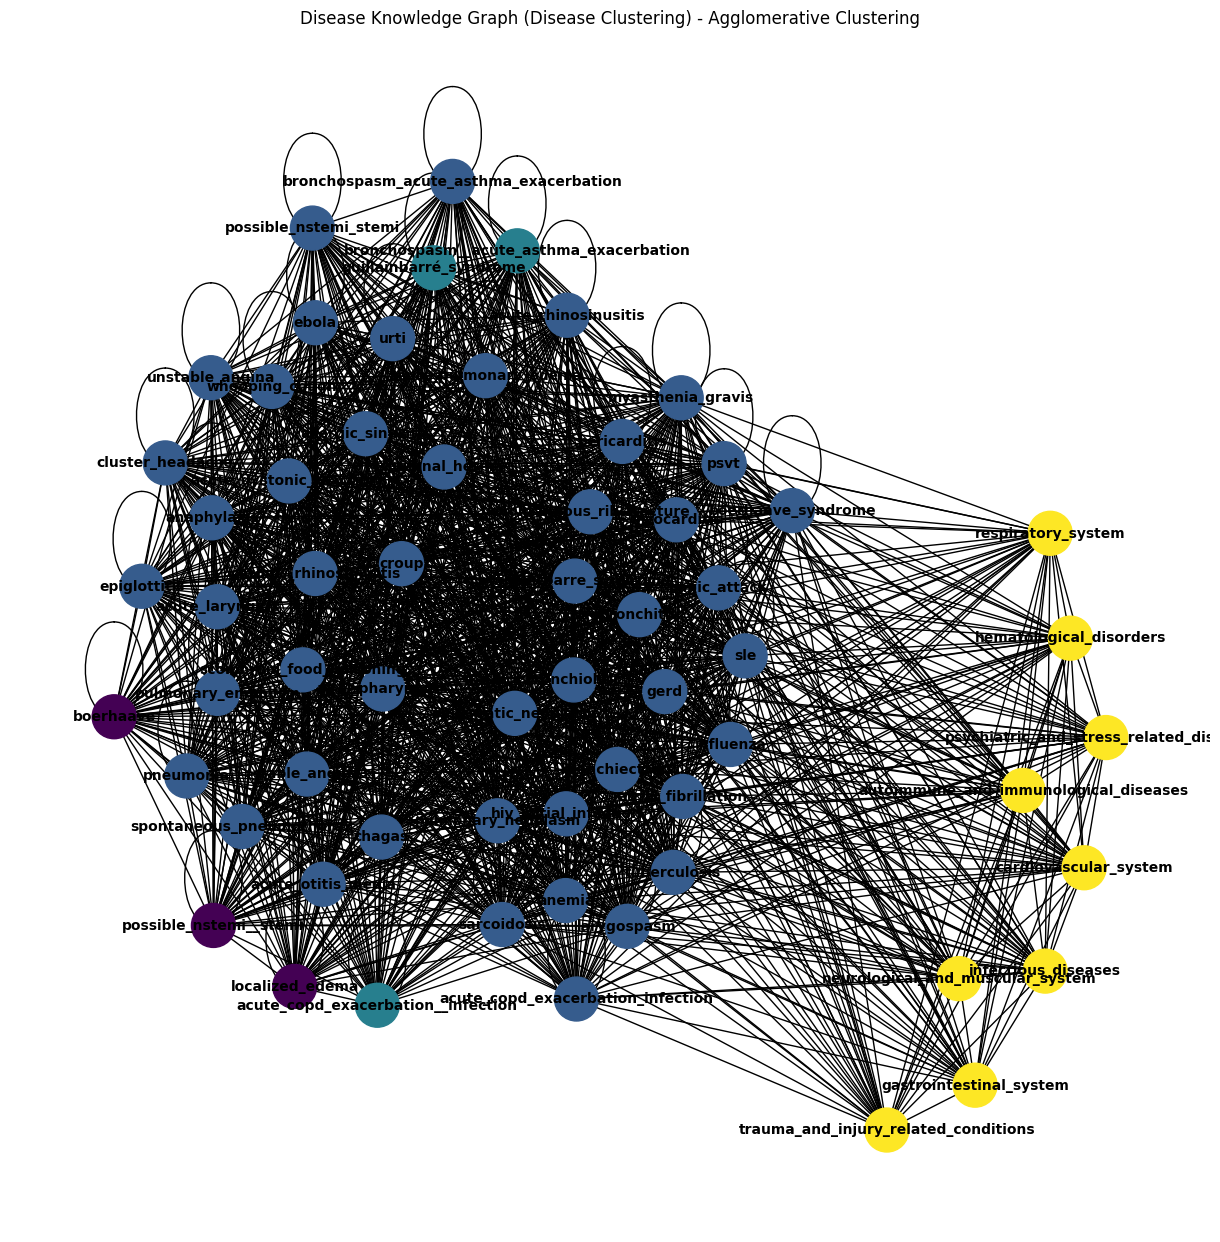

Top matching clinical features in the knowledge graph:
[62 15 28]
[10 62 15]
[62 15 28]


[array([62, 15, 28], dtype=int64),
 array([10, 62, 15], dtype=int64),
 array([62, 15, 28], dtype=int64)]

In [27]:
def match_query_to_kg_and_visualize(query, G, threshold=0.7, top_m=3):
    features = decompose_query(query)
    
    knowledge_graph_nodes = list(G.nodes)
    
    similarities = clinical_features_matching(features, knowledge_graph_nodes)
    
    valid_matches = apply_indicator_function(similarities, threshold)
    
    top_matches = retrieve_top_matches(similarities * valid_matches, m=top_m)

    visualize_disease_knowledge_graph(G)
    
    print("Top matching clinical features in the knowledge graph:")
    for match in top_matches:
        print(match)

    return top_matches

query = "shortness of breath, cough, wheezing"

data, agg_clust = agglomerative_clustering(data, num_clusters=8) 
G = create_disease_knowledge_graph(data) 

match_query_to_kg_and_visualize(query, G, threshold=0.7, top_m=3)


In [ ]:

def map_indices_to_names(top_matches, knowledge_graph_nodes):
    matched_names = []
    for match in top_matches:
        matched_names.append([knowledge_graph_nodes[i] for i in match])  
    return matched_names

query = "shortness of breath, cough, wheezing" 
knowledge_graph_nodes = list(G.nodes)  
similarities = clinical_features_matching(decompose_query(query), knowledge_graph_nodes)
valid_matches = apply_indicator_function(similarities, threshold=0.7)
top_matches = retrieve_top_matches(similarities * valid_matches, m=3)  

matched_names = map_indices_to_names(top_matches, list(G.nodes))

# The system retrueves n x m mathcing nodes in the G (Disease Knowledge Graph   )
print("Top matching clinical features in the knowledge graph:")
for match in matched_names:
    print(match)


Top matching clinical features in the knowledge graph:
['guillainbarré_syndrome', 'epiglottitis', 'sle']
['whooping_cough', 'guillainbarré_syndrome', 'epiglottitis']
['guillainbarré_syndrome', 'epiglottitis', 'sle']
